In [60]:
from visualize_utils import *
import matplotlib.pyplot as plt
import numpy as np
import copy
import torch
import torch.nn.functional as F

In [2]:
model_path = "./logs_r2/was_hw001_ma0275_ar015/models/weights_29"
models = load_models(model_path)
image_loader = ImageLoader(3, 1)


/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [100]:
def compute_errors1(gt, pred):
	"""Computation of error metrics between predicted and ground truth depths
	"""
	if isinstance(gt, torch.Tensor):
		gt = gt.detach().cpu().numpy()
	if isinstance(pred, torch.Tensor):
		pred = pred.detach().cpu().numpy()
	if pred.shape != gt.shape:
		height, width = gt.shape[2:]
		pred = F.interpolate(torch.from_numpy(pred), size=(height, width), mode='bilinear', align_corners=False).numpy()
	mask = np.logical_and(gt > MIN_DEPTH, gt < MAX_DEPTH)
	pred = pred[mask]
	gt = gt[mask]
	ratio = np.median(gt) / np.median(pred)
	pred = pred * ratio

	pred[pred < MIN_DEPTH] = MIN_DEPTH
	pred[pred > MAX_DEPTH] = MAX_DEPTH
	# gt[gt < MIN_DEPTH] = MIN_DEPTH
	# gt[gt > MAX_DEPTH] = MAX_DEPTH

	thresh = np.maximum((gt / pred), (pred / gt))
	a1 = (thresh < 1.25     ).mean()
	a2 = (thresh < 1.25 ** 2).mean()
	a3 = (thresh < 1.25 ** 3).mean()

	abs_diff=np.mean(np.abs(gt - pred))

	rmse = (gt - pred) ** 2
	rmse = np.sqrt(rmse.mean())

	rmse_log = (np.log(gt) - np.log(pred)) ** 2
	rmse_log = np.sqrt(rmse_log.mean())

	abs_rel = np.mean(np.abs(gt - pred) / gt)

	sq_rel = np.mean(((gt - pred) ** 2) / gt)

	return abs_diff,abs_rel, sq_rel, rmse_log, a1, a2, a3

In [56]:
def handle_gt_pred(gt, pred):
    gt_t = copy.deepcopy(gt)
    pred_t = copy.deepcopy(pred)
    gt_t = gt_t.detach().cpu()
    pred_t = pred_t.detach().cpu()
    if pred.shape != gt.shape:
        height, width = gt.shape[2:]
        pred_t = F.interpolate(pred_t, size=(height, width), mode='bilinear', align_corners=False)
    mask = np.logical_and(gt > MIN_DEPTH, gt < MAX_DEPTH)
    pred_m = pred_t[mask]
    gt_m = gt[mask]
    ratio = np.median(gt_m) / np.median(pred_m)
    pred_t = pred_t * ratio
    gt_t[gt_t < MIN_DEPTH] = MIN_DEPTH
    gt_t[gt_t > MAX_DEPTH] = MAX_DEPTH
    pred_t[pred_t < MIN_DEPTH] = MIN_DEPTH
    pred_t[pred_t > MAX_DEPTH] = MAX_DEPTH
    return gt_t, pred_t


In [92]:
test_fs = """
dataset4/keyframe4	26	l
dataset1/keyframe3	354	l
dataset2/keyframe4	135	l
dataset7/keyframe4	20    l
"""

lines = test_fs.strip().split("\n")
datasets = []
keyframes = []
frames = []
for line in lines:
    dataset, frame_index, side = line.split()
    dataset_id = int(dataset.split("/")[0].split("dataset")[1])
    keyframe_id = int(dataset.split("/")[1].split("keyframe")[1])
    frame_index = int(frame_index)
    datasets.append(dataset_id)
    keyframes.append(keyframe_id)
    frames.append(frame_index)


/tmp/ipykernel_2240485/3655715313.py:10: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  pred_m = pred_t[mask]
/tmp/ipykernel_2240485/3655715313.py:11: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  gt_m = gt[mask]


Dataset: 4, Keyframe: 4, Frame: 26:
      rmse |  abs_rel |   sq_rel | rmse_log |       a1 |       a2 |       a3 | 
&   2.419  &   0.059  &   0.299  &   0.080  &   0.976  &   1.000  &   1.000  \\

Dataset: 1, Keyframe: 3, Frame: 354:
      rmse |  abs_rel |   sq_rel | rmse_log |       a1 |       a2 |       a3 | 
&   2.777  &   0.051  &   0.318  &   0.069  &   0.991  &   1.000  &   1.000  \\

Dataset: 2, Keyframe: 4, Frame: 135:
      rmse |  abs_rel |   sq_rel | rmse_log |       a1 |       a2 |       a3 | 
&   1.459  &   0.028  &   0.098  &   0.047  &   0.991  &   1.000  &   1.000  \\

Dataset: 7, Keyframe: 4, Frame: 20:
      rmse |  abs_rel |   sq_rel | rmse_log |       a1 |       a2 |       a3 | 
&   2.819  &   0.057  &   0.289  &   0.080  &   0.992  &   1.000  &   1.000  \\



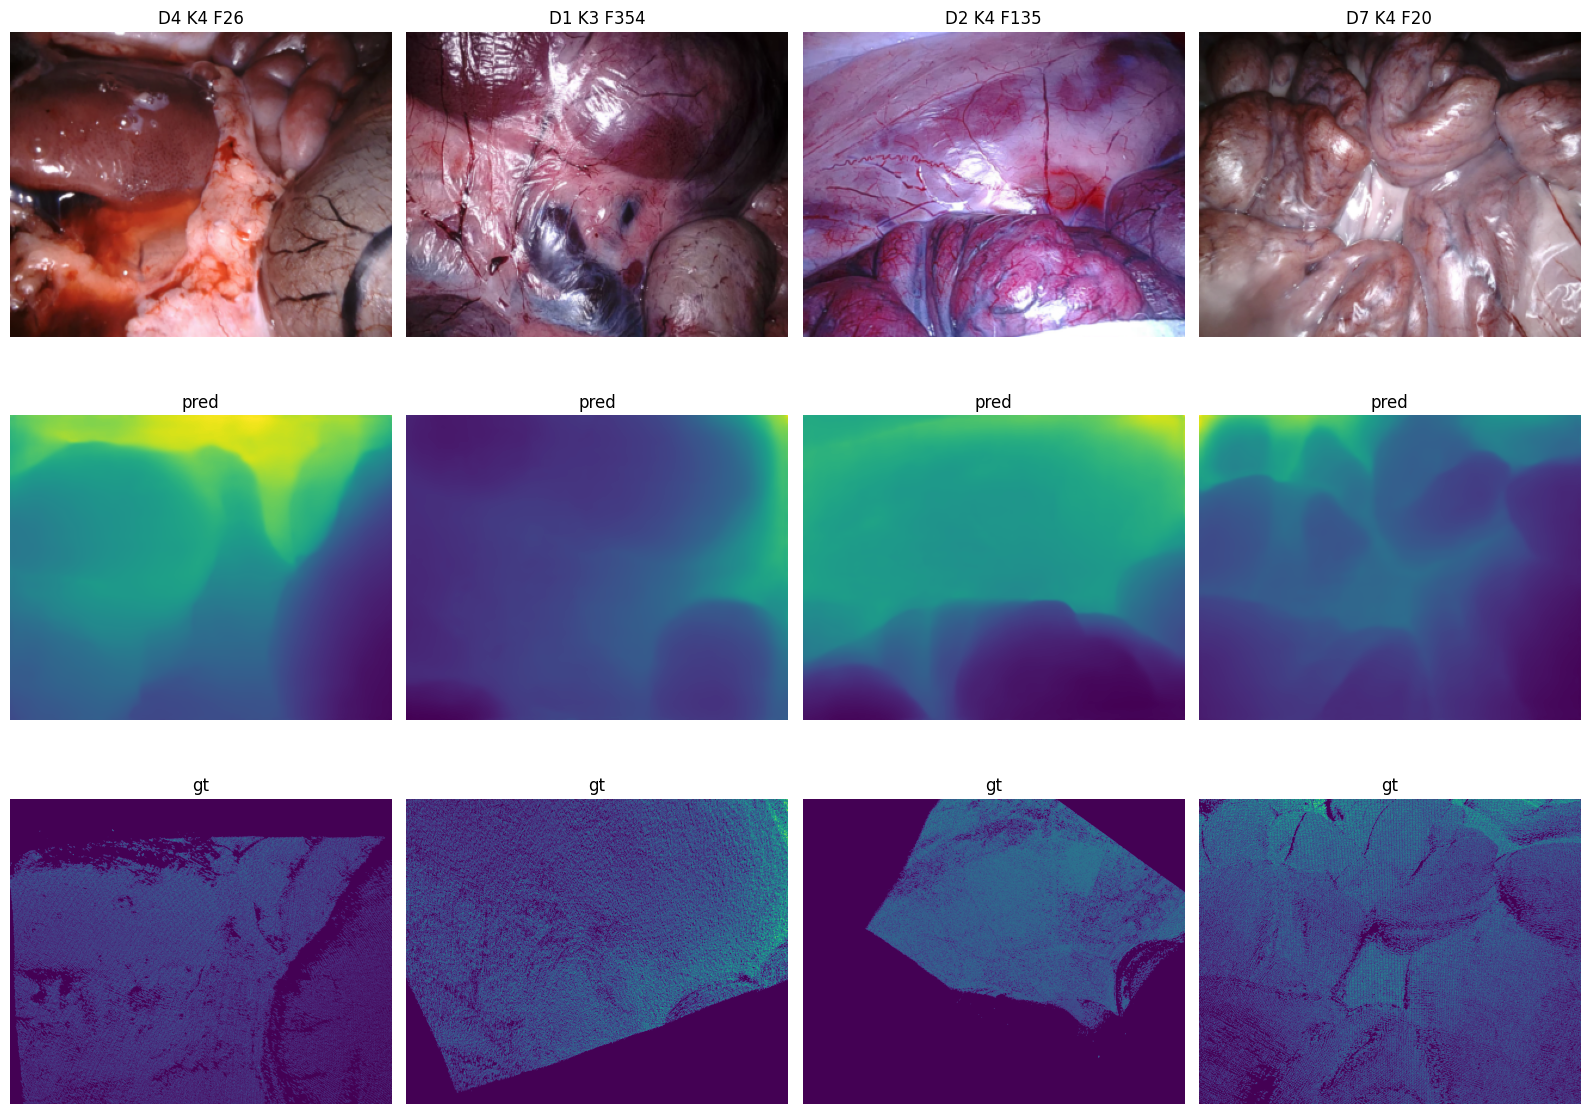

In [102]:
images = []
preds = []
gts = []
errors = []
image_titles = []
for dataset_id, keyframe_id, frame_index, i in zip(datasets, keyframes, frames, range(len(datasets))):
    image_loader.set_dataset(dataset_id)
    image_loader.set_keyframe(keyframe_id)
    image = image_loader.single(frame_index)
    gt = image_loader.single_gt(frame_index, "ori")
    depth = predict_depth(models, image)
    gt_t, pred_t = handle_gt_pred(gt, depth)
    images.append(image)
    preds.append(pred_t)
    gts.append(gt_t)
    image_titles.append("D{} K{} F{}".format(dataset_id, keyframe_id, frame_index))
    mean_errors = compute_errors1(gt, depth)
    print("Dataset: {}, Keyframe: {}, Frame: {}:".format(dataset_id, keyframe_id, frame_index))
    print("  " + ("{:>8} | " * 7).format("rmse","abs_rel", "sq_rel", "rmse_log", "a1", "a2", "a3"))
    print(("&{: 8.3f}  " * 7).format(*list(mean_errors)) + "\\\\")
    print()

images_to_show = images
images_to_show.extend(preds)
images_to_show.extend(gts)
image_titles.extend(["pred"]*len(preds))
image_titles.extend(["gt"]*len(gts))
plot_images(images_to_show, lines=3, titles=image_titles, cmaps="viridis")